In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [13]:
import ee
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import itertools
import sys
import re
import itertools
from io import StringIO
from tqdm.auto import tqdm
from pprint import pprint

import urllib.request
import requests

from dfply import *
import geopandas as gpd

from ast import literal_eval
from shapely.geometry import shape

# ! pip install geemap
# import geemap

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import filter_exclude, get_img_df
from Modules.Parallize_df import parallelize_dataframe
from Modules.Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

In [6]:
# function to compute the area ratio of each crop given the irrigated/rainfed water supply
def compute_crop_water_ratio(in_path,crop):

  in_dfs = actual_area >> mask(X.crop==crop)
  area_ratio = ee.Image(in_path).divide(cropland_area_sum)

  return ee.Image(area_ratio)

In [7]:
# # import GAEZ data from ee_asset
# GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# # actual harvested area
# actual_area = get_img_df(img_path = GAEZ_list,
#               theme = 'GAEZ_5',
#               variable = ['Harvested_area'],
#               time = '2010',
#               crop = ['Maize','Wetland_rice','Wheat'],
#               water = ['Rainfed','Irrigated'])

# # get the total cropland area
# cropland_area_sum = ee.ImageCollection([ee.Image(i) for i in actual_area['GEE_path'].tolist()]).sum()

# # get the area ratio
# actual_area['area_ratio'] = actual_area.apply(lambda row:compute_crop_water_ratio(row['GEE_path'],row['crop']),1 )

# # save GAEZ_2010_cropland to disk
# actual_area.to_pickle('./result_csv/actual_area.pkl')

actual_area = pd.read_pickle('./result_csv/actual_area.pkl')

In [8]:
# get yearbook cropland area
yearbook_path = '../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield'
crop_dict = {'maize':'Maize','wheat':'Wheat','rice':'Wetland_rice'}

# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

# loop through each crop
out_dfs = []
for k,v in crop_dict.items():
  df = pd.read_csv(f'{yearbook_path}/Area_{k}.csv')
  df = df.set_index('Zone').stack().reset_index()
  df.columns = ['Province','year','area_yearbook_kha']

  df['year'] = df['year'].astype(int)
  df['crop'] = v
  out_dfs.append(df)

# get the records in the NCP
yearbook_area = pd.concat(out_dfs).reset_index(drop=True).replace(city_cn_en) >> mask(X.Province.isin(city_cn_en.values()))

# save yearbook_cropland_area to disk
yearbook_area.to_csv('./result_csv/yearbook_area.csv',index=False)

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

### 1) compute the ratio of yearbook_cropland/GAEZ_cropland

In [18]:
# get the GEAZ_2010 cropland area
actual_area_2010_stats = []


for idx,row in tqdm(actual_area.iterrows(),total=len(actual_area)):
  crop = row['crop']
  water = row['water']
  cropland_img = ee.Image(row['GEE_path'])
  cropland_img = cropland_img.updateMask(cropland_img.gt(0))

  stats = ee.Image(cropland_img).reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                           for i in stats['features']}).T.reset_index()
  stats_df.columns = ['Province','GAEZ_area_2010_kha']
  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['year'] = 2010
  

  actual_area_2010_stats.append(stats_df)

# merge dfs
actual_area_2010_df = pd.concat(actual_area_2010_stats).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
# compute the difference between GAEZ_cropland and yearbook_cropland area
actual_area_2010_df_crop_sum = actual_area_2010_df.groupby(['Province','crop','year']).sum().reset_index()
actual_area_2010_df_crop_sum = actual_area_2010_df_crop_sum >> rename(GAEZ_area_2010_kha_sum = 'GAEZ_area_2010_kha')

# compute the difference
cropland_area_diff = actual_area_2010_df_crop_sum.merge(yearbook_area)
cropland_area_diff['delta'] = cropland_area_diff['area_yearbook_kha'] - cropland_area_diff['GAEZ_area_2010_kha_sum']

cropland_area_diff.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5156\1220483462.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Province,crop,year,GAEZ_area_2010_kha_sum,area_yearbook_kha,delta
0,Anhui,Maize,2010,652.328186,864.08,211.751814
1,Anhui,Wetland_rice,2010,3033.257141,2338.63,-694.627141
2,Anhui,Wheat,2010,1653.712613,2619.18,965.467387
3,Beijing,Maize,2010,315.041405,149.75,-165.291405
4,Beijing,Wetland_rice,2010,16.711141,0.30,-16.411141


In [20]:
# organize for plotting
cropland_area_diff_for_plot = (cropland_area_diff >> drop(['delta'])).set_index(['Province','crop','year']).stack().reset_index()
cropland_area_diff_for_plot = cropland_area_diff_for_plot.rename({'level_3':'source',0:'area'},axis='columns')

cropland_area_diff_for_plot_strip = cropland_area_diff_for_plot.copy()
cropland_area_diff_for_plot_strip.loc[cropland_area_diff_for_plot_strip['source']=='GAEZ_area_2010_kha_sum','area'] = 0

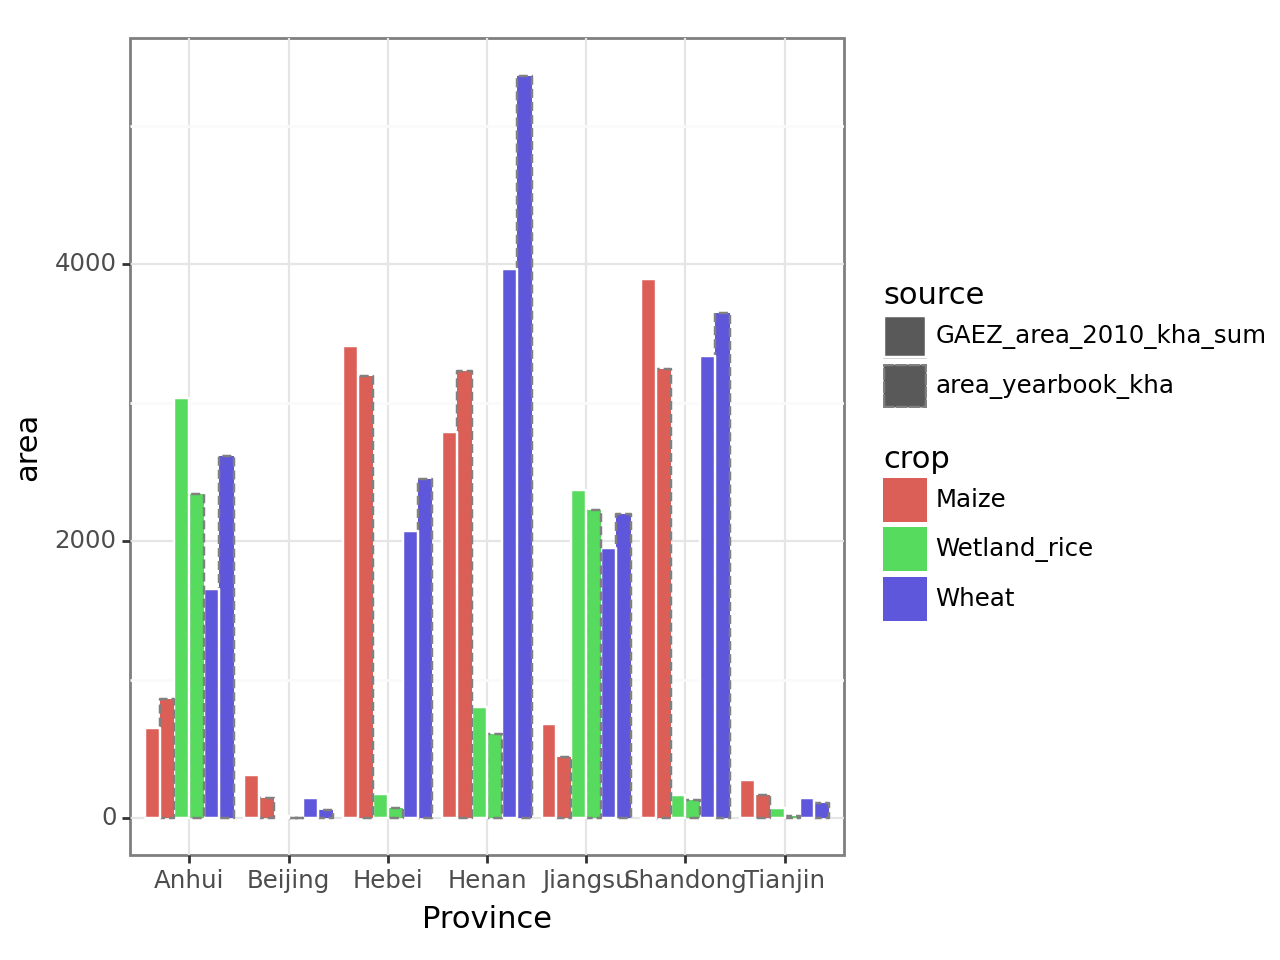

<Figure Size: (640 x 480)>

In [21]:
# has to make this figure via R, beccause fill_patter is not avaliable
(ggplot(cropland_area_diff_for_plot)
 + geom_col(aes(x='Province',y='area',fill='crop',color='source',linetype='source'),position='dodge')
 + scale_color_manual(values={'GAEZ_area_2010_kha_sum':'white','area_yearbook_kha':'grey'})
 + theme_bw()
 )

- Use R to make the plot because the package of "ggpattern" is not alaliable for Python
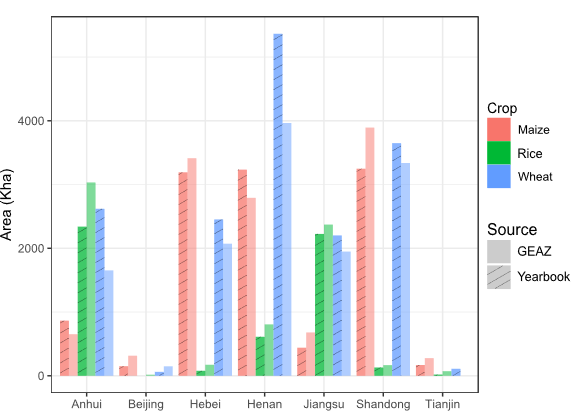

In [22]:
# compute the cropland_area_ratio = crop_area / crop_area_sum
actual_area_2010_df_with_ratio = actual_area_2010_df.merge(cropland_area_diff)
actual_area_2010_df_with_ratio['area_water_ratio'] = actual_area_2010_df_with_ratio['GAEZ_area_2010_kha'] \
                            / actual_area_2010_df_with_ratio['GAEZ_area_2010_kha_sum']

# compute the delta_area for each crop/water
actual_area_2010_df_with_ratio['delta_water_kha'] = actual_area_2010_df_with_ratio['delta'] * \
                             actual_area_2010_df_with_ratio['area_water_ratio']

# compute the delta_ratio
actual_area_2010_df_with_ratio = actual_area_2010_df_with_ratio \
            >> mutate(delta_ratio = (X.GAEZ_area_2010_kha + X.delta_water_kha)/X.GAEZ_area_2010_kha)

# get the necessary cols
actual_area_2010_df_with_ratio = actual_area_2010_df_with_ratio \
                    >> select(['Province','crop','water','year','delta_ratio'])

actual_area_2010_df_with_ratio = actual_area_2010_df_with_ratio.replace({np.nan:0})

actual_area_2010_df_with_ratio.head()

,Province,crop,water,year,delta_ratio
0,Shandong,Maize,Rainfed,2010,0.833854
1,Shandong,Maize,Irrigated,2010,0.833854
2,Henan,Maize,Rainfed,2010,1.158148
3,Henan,Maize,Irrigated,2010,1.158148
4,Beijing,Maize,Rainfed,2010,0.475334


### 2) clip the GAEZ_cropland with NCP_shp, then multiply the clipped img with delta_ratio

In [23]:
# get ee.shp boundary for each province
province_shp = {n:[ee.Feature(NCP_shp.filter(ee.Filter.eq('EN_Name',n)).first())] for n in  list(city_cn_en.values())}
province_shp_df = pd.DataFrame(province_shp).T.reset_index()
province_shp_df.columns = ['Province','shp']

In [24]:
# link GAEZ_2010_cropland with province_shp
actual_area_with_province_shp = actual_area.copy()
actual_area_with_province_shp['Province'] = [province_shp_df['Province'].tolist()] * len(actual_area_with_province_shp)
actual_area_with_province_shp['shp'] = [province_shp_df['shp'].tolist()] * len(actual_area_with_province_shp)
actual_area_with_province_shp = actual_area_with_province_shp.explode(['Province','shp']).reset_index(drop=True)

# link the delta_ratio with province
actual_area_with_delta_ratio = actual_area_with_province_shp.merge(actual_area_2010_df_with_ratio)
actual_area_with_delta_ratio = actual_area_with_delta_ratio >> select(['Province','crop','water','year','GEE_path','shp','delta_ratio'])

actual_area_with_delta_ratio.head()

,Province,crop,water,year,GEE_path,shp,delta_ratio
0,Beijing,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.475334
1,Tianjin,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.611075
2,Hebei,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.934920
3,Jiangsu,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",0.646848
4,Anhui,Maize,Rainfed,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Feature({\n ""functionInvocationValue"": {\n...",1.324609


In [25]:
# multiply the delta_ratio, then mosaic the imgs of different province to a single img
def multiply_ratio(row):
  in_img = ee.Image(row['GEE_path']).clip(row['shp']).multiply(row['delta_ratio'])
  return in_img

# apply the function
actual_area_with_delta_ratio['GAEZ_2010_cropland_corrcted'] = actual_area_with_delta_ratio.apply(lambda row:multiply_ratio(row),1)

# change name and save to disk
GAEZ_cropland_2010_corrected = actual_area_with_delta_ratio.copy() \
              >> select(['Province','crop','water','GAEZ_2010_cropland_corrcted'])

GAEZ_cropland_2010_corrected = GAEZ_cropland_2010_corrected.groupby(['crop','water'])\
                  .apply(lambda df:ee.ImageCollection(df['GAEZ_2010_cropland_corrcted'].tolist()).mosaic())\
                  .reset_index()

# rename cols and save to disk
GAEZ_cropland_2010_corrected.columns = ['crop','water','GAEZ_2010_cropland_corrcted']


# merge with the actual_area (raw GAEZ_2010_cropland) for compatibility
GAEZ_cropland_2010_corrected = GAEZ_cropland_2010_corrected.merge(actual_area)
GAEZ_cropland_2010_corrected.to_pickle('./result_csv/GAEZ_cropland_2010_corrected.pkl')

GAEZ_cropland_2010_corrected

,crop,water,GAEZ_2010_cropland_corrcted,theme,variable,time,GEE_path,area_ratio
0,Maize,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Maize,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Wetland_rice,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
3,Wetland_rice,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
4,Wheat,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."
5,Wheat,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_5,Harvested_area,2010,projects/earthengine-legacy/assets/users/wangj...,"ee.Image({\n ""functionInvocationValue"": {\n ..."


### 3) validate the corrected GAEZ_2010_cropland has the same area as the yearbook records

In [26]:
# get the GEAZ_2010 cropland area
actual_area_2010_stats_corrected = []


for idx,row in tqdm(GAEZ_cropland_2010_corrected.iterrows(),total=len(GAEZ_cropland_2010_corrected)):
  crop = row['crop']
  water = row['water']
  cropland_img = row['GAEZ_2010_cropland_corrcted']

  stats = ee.Image(cropland_img).reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                           for i in stats['features']}).T.reset_index()
  stats_df.columns = ['Province','GAEZ_area_2010_kha']
  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['year'] = 2010
  

  actual_area_2010_stats_corrected.append(stats_df)

# merge dfs
actual_area_2010_corrected_df = pd.concat(actual_area_2010_stats_corrected).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
# compute the difference between GAEZ_cropland_corrected and yearbook_cropland area
actual_area_2010_df_crop_sum_corrected = actual_area_2010_corrected_df.groupby(['Province','crop','year']).sum().reset_index()
cropland_area_diff_corrected = actual_area_2010_df_crop_sum_corrected.merge(yearbook_area)

cropland_area_diff_corrected['ratio'] = cropland_area_diff_corrected['GAEZ_area_2010_kha'] \
                      / cropland_area_diff_corrected['area_yearbook_kha']

cropland_area_diff_corrected['delta'] = cropland_area_diff_corrected['GAEZ_area_2010_kha'] \
                      - cropland_area_diff_corrected['area_yearbook_kha']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5156\1526753730.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [28]:
cropland_area_diff_corrected

,Province,crop,year,GAEZ_area_2010_kha,area_yearbook_kha,ratio,delta
0,Anhui,Maize,2010,857.272295,864.08,0.992121,-6.807705
1,Anhui,Wetland_rice,2010,2341.370721,2338.63,1.001172,2.740721
2,Anhui,Wheat,2010,2606.579754,2619.18,0.995189,-12.600246
3,Beijing,Maize,2010,159.875037,149.75,1.067613,10.125037
4,Beijing,Wetland_rice,2010,0.783900,0.30,2.613001,0.483900
5,Beijing,Wheat,2010,69.926094,61.59,1.135348,8.336094
6,Hebei,Maize,2010,3182.665875,3191.01,0.997385,-8.344125
7,Hebei,Wetland_rice,2010,77.033584,77.62,0.992445,-0.586416
8,Hebei,Wheat,2010,2445.062735,2451.44,0.997399,-6.377265
9,Henan,Maize,2010,3227.617764,3233.50,0.998181,-5.882236
